In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import mcnulty_util as mcu
from matplotlib import pyplot as plt
import time
%matplotlib inline

In [2]:
df = mcu.mcnulty_preprocessing()
backup = df.copy()

Initiating MAXIMUM data munging power
Luther Preprocessing Successful Woo Woo!



## Filtering by Issue Year

In [3]:
(df
 .assign(issue_year=lambda x: x.issue_d.dt.year)
 .groupby('issue_year')
 .size()
)

issue_year
2007      251
2008     1562
2009     4716
2010    11527
2011    19729
2012    49813
2013    73194
2014    74153
2015    30832
dtype: int64

In [4]:
mask = (df.issue_d >= '2013') & (df.issue_d >= '2014')
df = df.loc[mask, ]
df.to_csv(os.path.join('Data', 'lendingclub_clean.csv'))

## One Hot Encoding Functions

In [5]:
def label_encoding_helper(input_df, column):
    df = input_df.copy()
    x = df.loc[:, column]

    le = LabelEncoder()
    le.fit(x)
    df.loc[:, column] = le.transform(x)
    
    return df, le

## Loan Amount

In [6]:
loan_amount_mean = df.loan_amnt.mean()
"${:,.0f}".format(loan_amount_mean)

'$14,417'

## Interest Rate

In [7]:
interest_rate_mean = df.int_rate.mean()
"{:,.2f}%".format(interest_rate_mean)

'14.26%'

## Annual Income

In [8]:
annual_income_mean = df.annual_inc.mean()
"${:,.0f}".format(annual_income_mean)

'$74,737'

## Debt-to-Income

In [9]:
dti_mean = df.dti.mean()
"${:,.2f}".format(dti_mean)

'$17.84'

## Employment Length

In [10]:
df.emp_length.mode().values[0]

'10+ years'

In [11]:
df, le_emp_length = label_encoding_helper(df, 'emp_length')

## Term

In [12]:
df.term.mode().values[0]

'36 months'

In [13]:
df, le_term = label_encoding_helper(df, 'term')

## Purpose

In [14]:
df.purpose.mode().values[0]

'debt_consolidation'

In [15]:
df, le_purpose = label_encoding_helper(df, 'purpose')

## Grade

In [16]:
df.grade.mode().values[0]

'C'

In [17]:
df, le_grade = label_encoding_helper(df, 'grade')

## Random Forest

In [18]:
features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'term', 'purpose', 'grade']
dependent = 'default'
model_name = 'Random Forest'
X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier(n_jobs=-1)
%time rf.fit(X_train, y_train)

Wall time: 5.3 s


RandomForestClassifier(n_jobs=-1)

In [19]:
yhat_train = rf.predict(X_train)
training_accuracy = metrics.accuracy_score(y_train, yhat_train)
yhat_test = rf.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
accuracy_str = "Training Set Accuracy: {:>10.4%}\nTest Set Accuracy: {:>14.4%}".format(training_accuracy, test_accuracy)
print(accuracy_str)

Training Set Accuracy:   99.9986%
Test Set Accuracy:       73.2668%


## Random Forest with Grid Search

In [20]:
features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'term', 'purpose', 'grade']
dependent = 'default'

X, y = df.loc[:, features], df.loc[:, dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

best_params = {"max_depth": None, "max_features": "log2", "min_samples_leaf": 2, "min_samples_split": 2, "n_estimators": 64}
rf = RandomForestClassifier(n_jobs=-1, **best_params)
%time rf.fit(X_train, y_train)

Wall time: 4.18 s


RandomForestClassifier(max_features='log2', min_samples_leaf=2, n_estimators=64,
                       n_jobs=-1)

In [21]:
yhat_train = rf.predict(X_train)
training_accuracy = metrics.accuracy_score(y_train, yhat_train)
yhat_test = rf.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
accuracy_str = "Training Set Accuracy: {:>10.4%}\nTest Set Accuracy: {:>14.4%}".format(training_accuracy, test_accuracy)
print(accuracy_str)

Training Set Accuracy:   96.0548%
Test Set Accuracy:       73.3505%


## ROC Curve

[Reference Link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.672


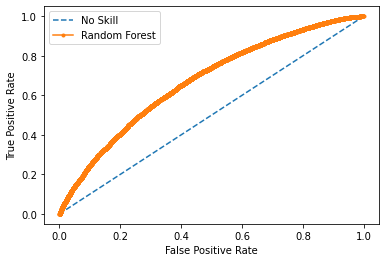

In [22]:
# predict probabilities and keep probabilities for the positive outcome only
y_pred_probs = rf.predict_proba(X_test)[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
rf_auc = metrics.roc_auc_score(y_test, y_pred_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, y_pred_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Precision-Recall Curve

[Reference Link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

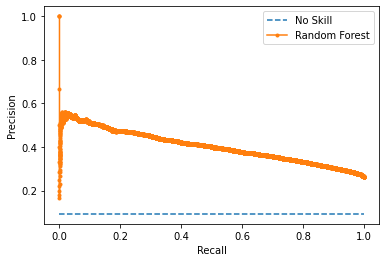

In [23]:
# predict probabilities and keep probabilities for the positive outcome only
y_pred_probs = rf.predict_proba(X_test)[:, 1]
# predict class values
y_pred = rf.predict(X_test)
# calculate precision and recall for each threshold
rf_precision, rf_recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_probs)
# calculate scores
#rf_f1, rf_auc = metrics.f1_score(y_test, y_pred), metrics.auc(rf_precision, rf_recall)
# summarize scores
#print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
no_skill = len(y_pred[y_pred==1]) / len(y_pred)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [24]:
metrics.precision_recall_curve(y_test, y_pred_probs)

(array([0.26320499, 0.26380972, 0.26381735, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99780678e-01, 9.99780678e-01, ...,
        2.19322294e-04, 1.09661147e-04, 0.00000000e+00]),
 array([0.00000000e+00, 2.57554945e-04, 4.88281250e-04, ...,
        8.77343750e-01, 8.82291667e-01, 8.82552083e-01]))

## Recall at different thresholds

In [25]:
def predict_with_threshold(model, X, threshold):
    y_pred_prob = rf.predict_proba(X_test)[:, 1]
    mask = y_pred_prob > threshold
    y_pred = np.where(mask, 1, 0)
    return y_pred

""" Check the function is written correctly """
sum(predict_with_threshold(rf, X_test, 0.5) != rf.predict(X_test))

0

In [26]:
def precision_and_recall_with_threshold(model, X, y_true, threshold):
    y_pred = predict_with_threshold(model, X, threshold)
    recall_score = metrics.recall_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred)
    return precision_score, recall_score

In [27]:
precision_and_recall_scores = dict()
thresholds = [0.1 * x for x in range(0, int(1/0.1) + 1)]
for threshold in thresholds:
    precision_score, recall_score = precision_and_recall_with_threshold(rf, X_test, y_test, threshold)
    precision_and_recall_scores[threshold] = [precision_score, recall_score]
df_pr = pd.DataFrame.from_dict(precision_and_recall_scores, orient='index', columns=['Precision', 'Recall'])

C:\Users\Brendan Non-Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Brendan Non-Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
df_pr.applymap('{:0.2%}'.format)

,Precision,Recall
0.0,26.38%,99.98%
0.1,29.43%,93.16%
0.2,34.07%,76.74%
0.3,38.83%,55.76%
0.4,43.46%,34.42%
0.5,48.23%,17.04%
0.6,52.01%,6.39%
0.7,54.80%,1.69%
0.8,34.38%,0.12%
0.9,0.00%,0.00%


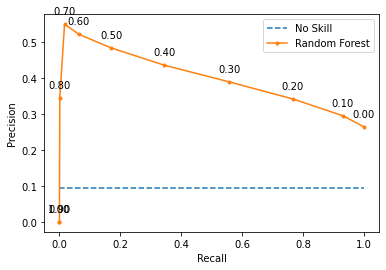

In [29]:
# predict probabilities and keep probabilities for the positive outcome only
y_pred_probs = rf.predict_proba(X_test)[:, 1]
# predict class values
y_pred = rf.predict(X_test)
# calculate precision and recall for each threshold
rf_precision, rf_recall = df_pr.Precision, df_pr.Recall
# calculate scores
#rf_f1, rf_auc = metrics.f1_score(y_test, y_pred), metrics.auc(rf_precision, rf_recall)
# summarize scores
#print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
no_skill = len(y_pred[y_pred==1]) / len(y_pred)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# add labels
for x,y, threshold in zip(rf_recall, rf_precision, df_pr.index):
    label = "{:.2f}".format(threshold)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# show the plot
plt.show()

In [30]:
(df_pr.loc[[0.5, 0.1], ]
 .applymap('{:0.2%}'.format)
)

,Precision,Recall
0.5,48.23%,17.04%
0.1,29.43%,93.16%


## Blog Objects and Testing

In [31]:
def label_encoder_map(le):
    labels = list(le.classes_)
    labels_encoded = le.transform(labels)
    le_encoder_map = dict(zip(labels, labels_encoded))
    return le_encoder_map

In [32]:
emp_length_map = label_encoder_map(le_emp_length)
emp_length_map

{'1 year': 0,
 '10+ years': 1,
 '2 years': 2,
 '3 years': 3,
 '4 years': 4,
 '5 years': 5,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9,
 '< 1 year': 10,
 'Not provided': 11}

In [33]:
term_map = label_encoder_map(le_term)
term_map

{'36 months': 0, '60 months': 1}

In [34]:
purpose_map = label_encoder_map(le_purpose)
purpose_map

{'car': 0,
 'credit_card': 1,
 'debt_consolidation': 2,
 'home_improvement': 3,
 'house': 4,
 'major_purchase': 5,
 'medical': 6,
 'moving': 7,
 'other': 8,
 'renewable_energy': 9,
 'small_business': 10,
 'vacation': 11,
 'wedding': 12}

In [35]:
grade_map = label_encoder_map(le_grade)
grade_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

In [36]:
row = pd.DataFrame({
        'loan_amnt': 13658.0, 
        'int_rate': 17, 
        'annual_inc': 150000, 
        'dti': 16.7, 
        'emp_length': emp_length_map['10+ years'], 
        'term': term_map['36 months'], 
        'purpose': purpose_map['debt_consolidation'], 
        'grade': grade_map['B'],
    },
    index=[0]
)
rf.predict_proba(row)[0, 1]

0.22932657163742692

## Pickling

In [37]:
import pickle

filename = 'rf.pkl'
with open(filename, 'wb') as f:
    pickle.dump(rf, f)